<a href="https://colab.research.google.com/github/raghavashok24/nexusai_research_raghav/blob/main/updated_complete_EWS_nexusai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 9.4 MB/s eta 0:00:00


In [2]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor
import shap
import optuna
import io
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBRegressor
from google.colab import files
from sklearn.linear_model import Ridge
from sklearn.base import clone
from scipy.stats import spearmanr
from matplotlib.colors import ListedColormap

In [ ]:
# file upload
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

Saving updated_dataset_logistic_risk_score.csv to updated_dataset_logistic_risk_score.csv


In [ ]:
# preprocessing
target_col = 'probabilistic_risk_score'
flag_cols = [col for col in df.columns if 'was_imputed' in col.lower()]
exclude_from_model = ['num_thresholds_exceeded'] + flag_cols

# Drop non-predictive metadata
non_predictive = ['Bank_Name', 'State', 'Region', 'QuarterLabel']
df.drop(columns=[col for col in non_predictive if col in df.columns], inplace=True)

# Time-based split
df_sorted = df.sort_values(by='Quarter').reset_index(drop=True)
split_point = int(df_sorted['Quarter'].max() * 0.8)

train_df = df_sorted[df_sorted['Quarter'] <= split_point].copy()
test_df = df_sorted[df_sorted['Quarter'] > split_point].copy()

# Target variable
y_train = train_df[target_col]
y_test = test_df[target_col]

# X variables (masking num_thresholds_exceeded & flags from both train/test)
X_train = train_df.drop(columns=[target_col] + exclude_from_model, errors='ignore')
X_test = test_df.drop(columns=[target_col] + exclude_from_model, errors='ignore')

In [ ]:
# lightgbm baseline model
baseline_lgb = LGBMRegressor(random_state=42)
baseline_lgb.fit(X_train, y_train)

# Predict and evaluate
baseline_preds = baseline_lgb.predict(X_test)

baseline_mse = mean_squared_error(y_test, baseline_preds)
baseline_r2 = r2_score(y_test, baseline_preds)
baseline_brier = baseline_mse

print("=== Baseline LightGBM ===")
print(f"MSE: {baseline_mse:.4f}")
print(f"R²: {baseline_r2:.4f}")
print(f"Adapted Brier Score: {baseline_brier:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3923
[LightGBM] [Info] Number of data points in the train set: 990, number of used features: 23
[LightGBM] [Info] Start training from score 0.295203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
=== Baseline LightGBM ===
MSE: 0.0039
R²: 0.8565
Adapted Brier Score: 0.0039


In [ ]:
# optuna hyperparameter tuning
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'force_col_wise': True,
        'n_jobs': -1
    }

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse  # Minimizing MSE

# Run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

# Retrieve best model
best_params = study.best_params
best_params['random_state'] = 42
best_params['force_col_wise'] = True
best_params['n_jobs'] = -1

tuned_lgb = LGBMRegressor(**best_params)
tuned_lgb.fit(X_train, y_train)
y_pred_tuned = tuned_lgb.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred_tuned)
r2 = r2_score(y_test, y_pred_tuned)
brier_score = mse

print("=== Optuna Tuned LightGBM ===")
print(f"Best Params: {best_params}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adapted Brier Score: {brier_score:.4f}")

[I 2025-06-20 18:54:59,628] A new study created in memory with name: no-name-061f47d7-90a7-43ba-8bff-47637e2308c4


  0%|          | 0/40 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Retrieve best parameters and reinitialize tuned model
best_params = study.best_params
best_params['random_state'] = 42
best_params['force_col_wise'] = True
best_params['n_jobs'] = -1

# Create and train final tuned model
tuned_lgb = LGBMRegressor(**best_params)
tuned_lgb.fit(X_train, y_train)

# Predict and evaluate using the tuned model
y_pred = tuned_lgb.predict(X_test)

# Save predictions globally so all plots use tuned model
y_pred_tuned = y_pred

# === Evaluation After Optuna-Tuned Model ===
train_pred = tuned_lgb.predict(X_train)
test_pred = tuned_lgb.predict(X_test)

train_mse = mean_squared_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("=== Evaluation: Optuna-Tuned LightGBM ===")
print(f"Train R²: {train_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train Brier Score (Adapted): {train_mse:.4f}")
print("-" * 30)
print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test Brier Score (Adapted): {test_mse:.4f}")


[LightGBM] [Info] Total Bins 3923
[LightGBM] [Info] Number of data points in the train set: 990, number of used features: 23
[LightGBM] [Info] Start training from score 0.295203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/tmp/ipython-input-38-3021711264.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipython-input-38-3021711264.py:18: UserWarning: 
The palette list has fewer values (15) than needed (23) and will cycle, which may produce an uninterpretable plot.
  barplot = sns.barplot(


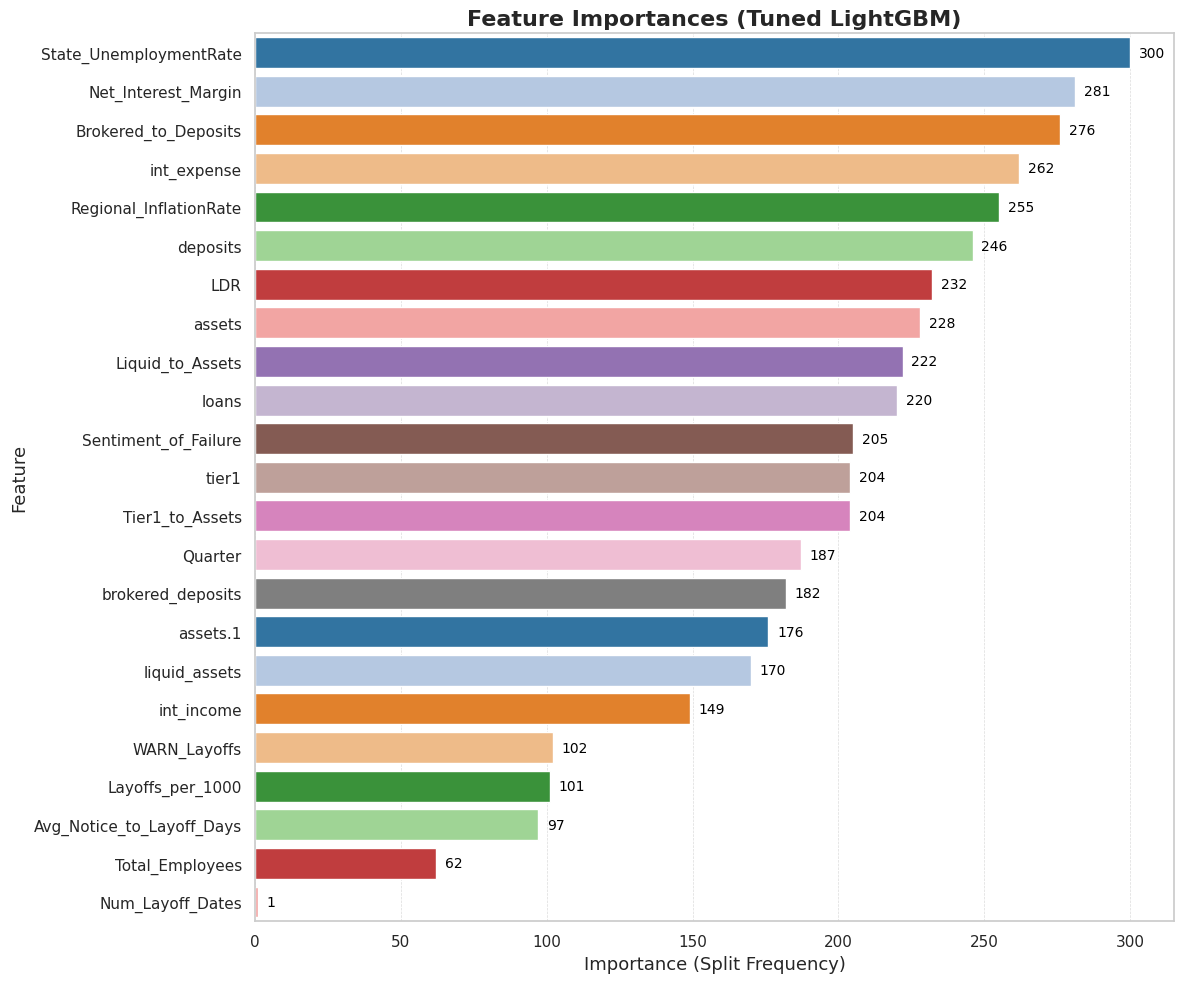

In [ ]:
# lightgbm feature importance
# Prepare feature importance data
feat_imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tuned_lgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Keep only the top 15 features
top_feat_imp_df = feat_imp_df.head(15).sort_values(by='Importance', ascending=True)

# color palette
colors = sns.color_palette("tab20", n_colors=15)

# Plot
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

barplot = sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
    palette=colors
)

# Annotate value on right end of each bar
for i, (importance, feature) in enumerate(zip(feat_imp_df['Importance'], feat_imp_df['Feature'])):
    plt.text(
        importance + max(feat_imp_df['Importance']) * 0.01,  # slight offset
        i,
        f'{importance:,}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

# Formatting
plt.title('Feature Importances (Tuned LightGBM)', fontsize=16, fontweight='bold')
plt.xlabel('Importance (Split Frequency)', fontsize=13)
plt.ylabel('Feature', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

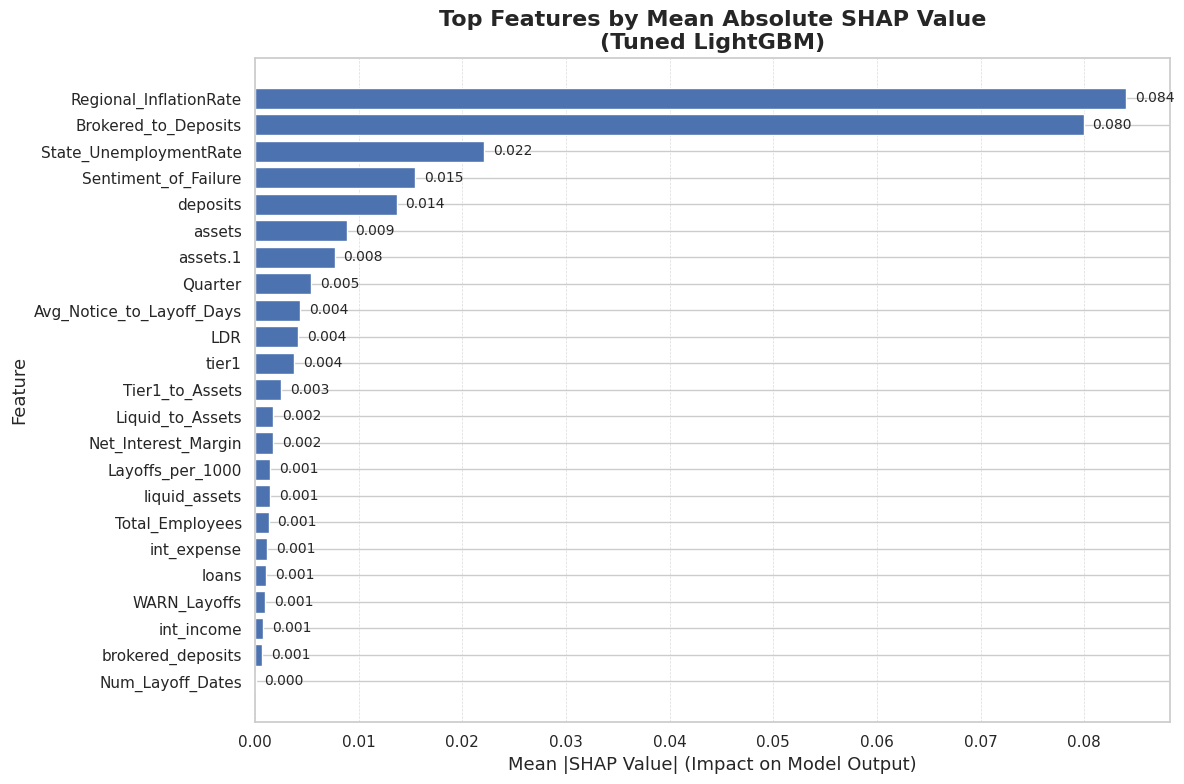

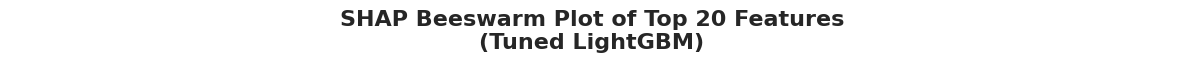

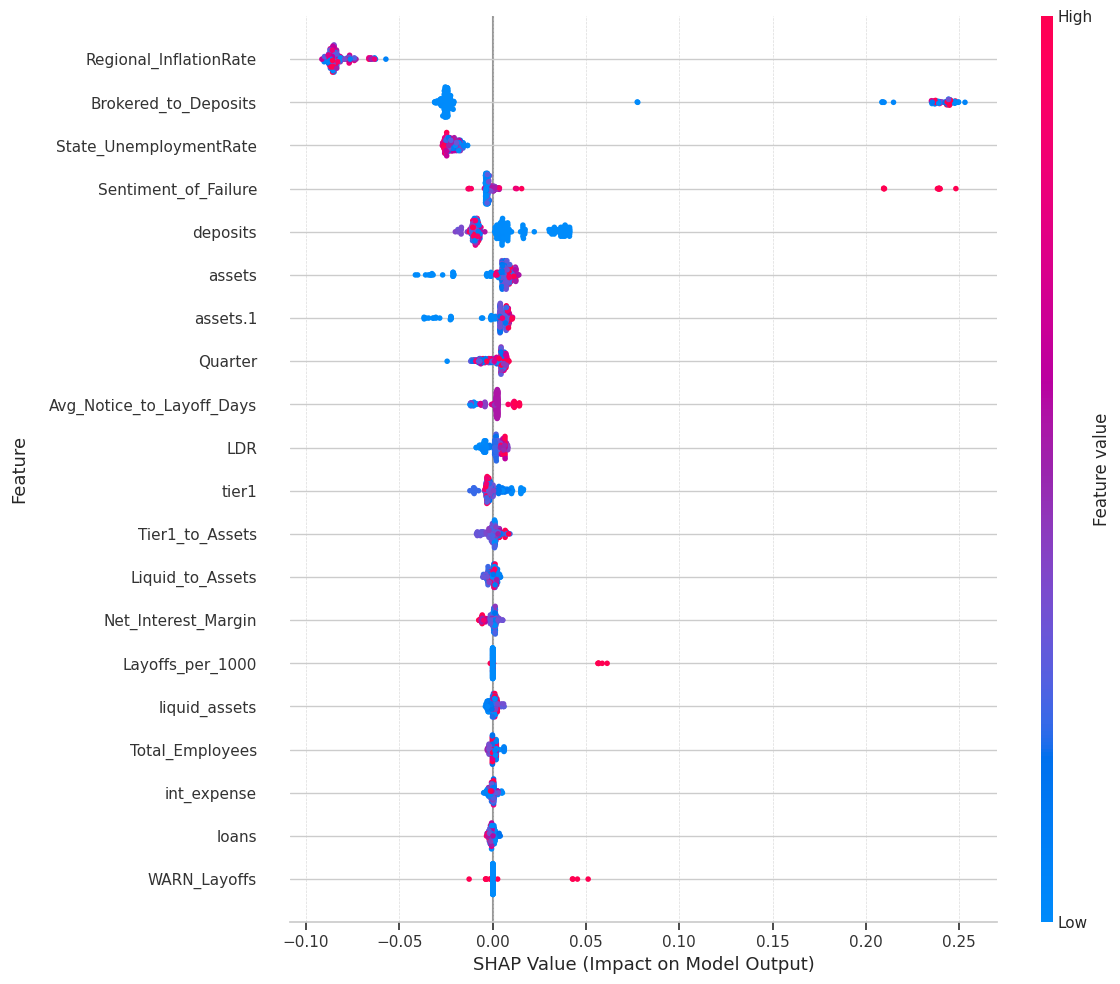

In [ ]:
# Recalculate SHAP values
explainer = shap.Explainer(tuned_lgb, X_train)
shap_values = explainer(X_test)

# Define custom color palettes
bar_color = sns.color_palette("deep")[0]
cmap_beeswarm = plt.get_cmap("coolwarm")

# SHAP Bar Plot
mean_abs_shap = pd.DataFrame({
    'Feature': X_test.columns,
    'MeanAbsSHAP': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='MeanAbsSHAP', ascending=True)

plt.figure(figsize=(12, 8))
bars = plt.barh(
    y=mean_abs_shap['Feature'],
    width=mean_abs_shap['MeanAbsSHAP'],
    color=bar_color
)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(mean_abs_shap['MeanAbsSHAP']) * 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.3f}', va='center', ha='left', fontsize=10)

# Formatting
plt.title("Top Features by Mean Absolute SHAP Value\n(Tuned LightGBM)", fontsize=16, fontweight='bold')
plt.xlabel("Mean |SHAP Value| (Impact on Model Output)", fontsize=13)
plt.ylabel("Feature", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# Spacer between plots
print("\n" * 3)

# SHAP Beeswarm Plot
# Custom plot title using matplotlib
plt.figure(figsize=(12, 1))
plt.axis("off")
plt.title("SHAP Beeswarm Plot of Top 20 Features\n(Tuned LightGBM)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Actual beeswarm plot
shap.summary_plot(
    shap_values,
    X_test,
    max_display=20,
    plot_size=(12, 10),
    color=cmap_beeswarm,
    show=False
)

plt.ylabel("Feature", fontsize=13, labelpad=15)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# define feature groups for ablation test
accounting_features = [
    'loans', 'tier1', 'assets', 'int_income', 'int_expense', 'LDR',
    'Tier1_to_Assets', 'Net_Interest_Margin', 'liquid_assets',
    'assets.1', 'brokered_deposits', 'deposits',
    'Liquid_to_Assets', 'Brokered_to_Deposits'
]

macro_features = [
    'Regional_InflationRate', 'State_UnemploymentRate'
]

non_accounting_features = [
    'Total_Employees', 'WARN_Layoffs', 'Layoffs_per_1000',
    'Num_Layoff_Dates', 'Avg_Notice_to_Layoff_Days',
    'Sentiment_of_Failure'
]

# preserve quarter since it was in model training
quarter_col = ['Quarter']

[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 990, number of used features: 14
[LightGBM] [Info] Start training from score 0.295203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/tmp/ipython-input-13-1081923986.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


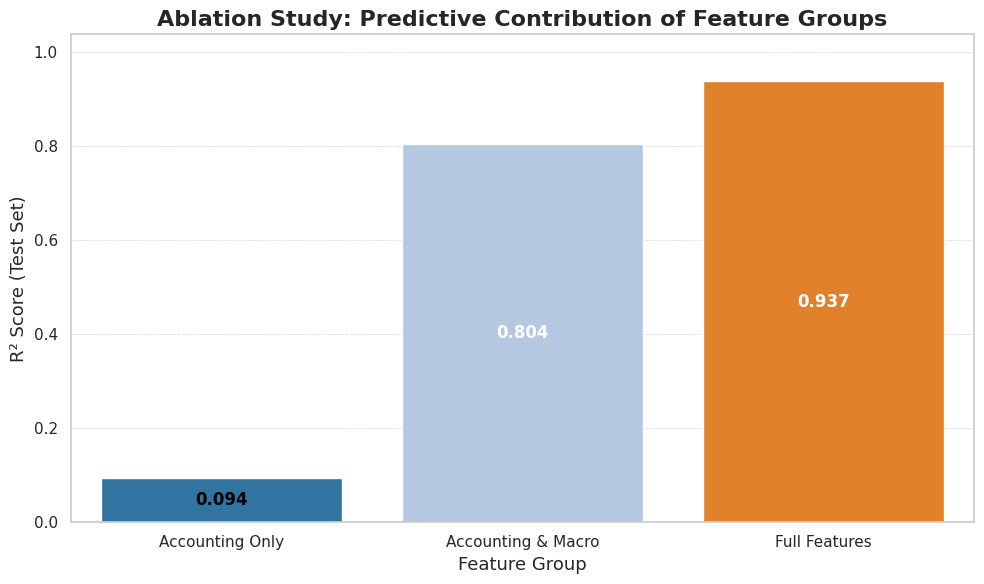

In [ ]:
accounting_features = [
    'loans', 'tier1', 'assets', 'int_income', 'int_expense', 'LDR',
    'Tier1_to_Assets', 'Net_Interest_Margin', 'liquid_assets',
    'assets.1', 'brokered_deposits', 'deposits',
    'Liquid_to_Assets', 'Brokered_to_Deposits'
]

macro_features = [
    'Regional_InflationRate', 'State_UnemploymentRate'
]

non_accounting_features = [
    'Total_Employees', 'WARN_Layoffs', 'Layoffs_per_1000',
    'Num_Layoff_Dates', 'Avg_Notice_to_Layoff_Days',
    'Sentiment_of_Failure'
]

# Ablation Feature Sets
feature_sets = {
    'Accounting Only': accounting_features,
    'Accounting & Macro': accounting_features + macro_features,
    'Full Features': accounting_features + macro_features + non_accounting_features
}
ordered_labels = ['Accounting Only', 'Accounting & Macro', 'Full Features']

# Compute R² with cloned tuned model
ablation_results = {}
for label in ordered_labels:
    selected_features = feature_sets[label]
    X_train_ab = X_train[selected_features]
    X_test_ab = X_test[selected_features]

    ab_model = clone(tuned_lgb)
    ab_model.fit(X_train_ab, y_train)
    y_pred_ab = ab_model.predict(X_test_ab)

    ab_r2 = r2_score(y_test, y_pred_ab)
    ablation_results[label] = ab_r2

# Format Results for Plot
ablation_df = pd.DataFrame({
    'Feature Set': ordered_labels,
    'R2': [ablation_results[label] for label in ordered_labels]
})

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab20")[:3]  # First 3 solid colors

barplot = sns.barplot(
    data=ablation_df,
    x='Feature Set',
    y='R2',
    palette=colors,
    order=ordered_labels
)

# Annotate R² inside each bar
for i, row in ablation_df.iterrows():
    plt.text(
        x=i,
        y=row.R2 / 2,
        s=f"{row.R2:.3f}",
        ha='center',
        va='center',
        fontsize=12,
        color='white' if row.R2 > 0.5 else 'black',
        fontweight='bold'
    )

# Final formatting
plt.title("Ablation Study: Predictive Contribution of Feature Groups", fontsize=16, fontweight='bold')
plt.ylabel("R² Score (Test Set)", fontsize=13)
plt.xlabel("Feature Group", fontsize=13)
plt.ylim(0, max(ablation_df['R2']) + 0.1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Use tuned LightGBM from earlier
models = {
    'Tuned LightGBM': tuned_lgb,
    'Random Forest': RandomForestRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'XGBoost': XGBRegressor(random_state=42)
}

print("=== Model Benchmarking ===")
for name, model in models.items():
    # Only retrain if not already tuned
    if name != 'Tuned LightGBM':
        model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    brier = mse  # Adapted Brier = MSE in regression

    print(f"{name} -> MSE: {mse:.4f}, R²: {r2:.4f}, Brier: {brier:.4f}")

=== Model Benchmarking ===
Tuned LightGBM -> MSE: 0.0016, R²: 0.9416, Brier: 0.0016
Random Forest -> MSE: 0.0039, R²: 0.8593, Brier: 0.0039
Ridge Regression -> MSE: 0.0218, R²: 0.2032, Brier: 0.0218


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.85054e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


XGBoost -> MSE: 0.0046, R²: 0.8325, Brier: 0.0046


In [ ]:
# Prepare results
results = {
    'Model': [],
    'R2 Score': [],
    'MSE': []
}

# Compute scores using predefined 'models' dict
for name, model in models.items():
    if name != 'Tuned LightGBM':
        model.fit(X_train, y_train)

    preds = model.predict(X_test)
    results['Model'].append(name)
    results['R2 Score'].append(r2_score(y_test, preds))
    results['MSE'].append(mean_squared_error(y_test, preds))

results_df = pd.DataFrame(results)

# Plotting Setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

colors = sns.color_palette("tab20")[:len(results_df)]

# R² Score Plot
sns.barplot(
    ax=axes[0],
    data=results_df,
    x='Model',
    y='R2 Score',
    palette=colors
)
axes[0].set_title("Model Comparison: R² Score", fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("R² Score", fontsize=12)
axes[0].set_xlabel("")
axes[0].tick_params(axis='x', rotation=20)
for i, row in results_df.iterrows():
    axes[0].text(i, row['R2 Score'] + 0.02, f"{row['R2 Score']:.3f}", ha='center', fontsize=11, fontweight='bold')

#sns.barplot(
    ax=axes[1],
    data=results_df,
    x='Model',
    y='MSE',
    palette=colors

axes[1].set_title("Model Comparison: Mean Squared Error", fontsize=14, fontweight='bold')
axes[1].set_ylabel("MSE (Lower is Better)", fontsize=12)
axes[1].set_xlabel("Model", fontsize=12)
axes[1].tick_params(axis='x', rotation=20)
for i, row in results_df.iterrows():
    axes[1].text(i, row['MSE'] * 1.02, f"{row['MSE']:.4f}", ha='center', fontsize=11, fontweight='bold')

# Final Formatting
plt.suptitle("Model Performance Comparison", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

NameError: name 'models' is not defined

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.85054e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


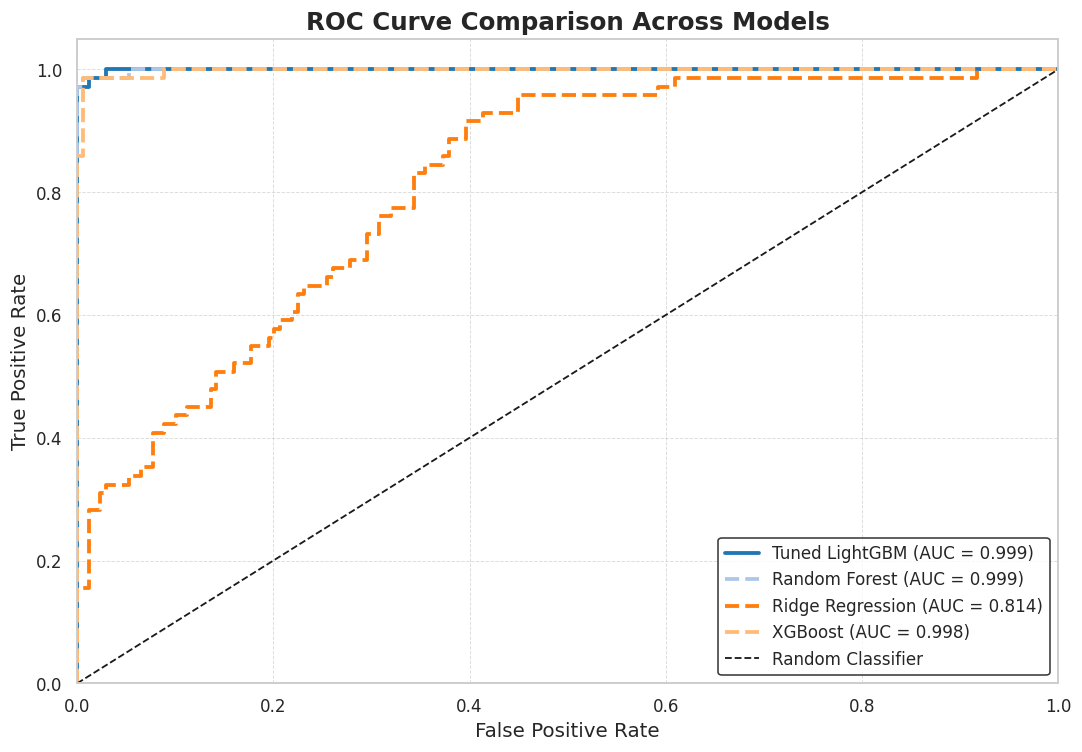

In [ ]:
#AUROC Plot
# Binarize Target
threshold = 0.5
y_test_binary = (y_test >= threshold).astype(int)

# Define Models
models = {
    'Tuned LightGBM': tuned_lgb,
    'Random Forest': RandomForestRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'XGBoost': XGBRegressor(random_state=42)
}

# Compute ROC/AUC
roc_results = {}

for name, model in models.items():
    if name not in ['Tuned LightGBM', 'Tuned XGBoost']:
        model.fit(X_train, y_train)

    preds = model.predict(X_test)

    # Normalize for Ridge
    if name == "Ridge Regression":
        preds = (preds - preds.min()) / (preds.max() - preds.min())

    fpr, tpr, _ = roc_curve(y_test_binary, preds)
    auc = roc_auc_score(y_test_binary, preds)
    roc_results[name] = (fpr, tpr, auc)

# Plot Setup
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7), dpi=110)
colors = sns.color_palette("tab20", n_colors=len(roc_results))

# Plot ROC Curves
for i, (name, (fpr, tpr, auc)) in enumerate(roc_results.items()):
    plt.plot(
        fpr, tpr,
        label=f"{name} (AUC = {auc:.3f})",
        linewidth=2.5,
        linestyle='-' if 'Tuned' in name else '--',
        color=colors[i]
    )

# Reference diagonal
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.2, label="Random Classifier")

# Formatting
plt.title("ROC Curve Comparison Across Models", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

# Legend
plt.legend(loc='lower right', fontsize=11, frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.85054e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/tmp/ipython-input-22-394858897.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-22-394858897.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-22-394858897.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-22-394858897.py:42: FutureWarning: 

Passi

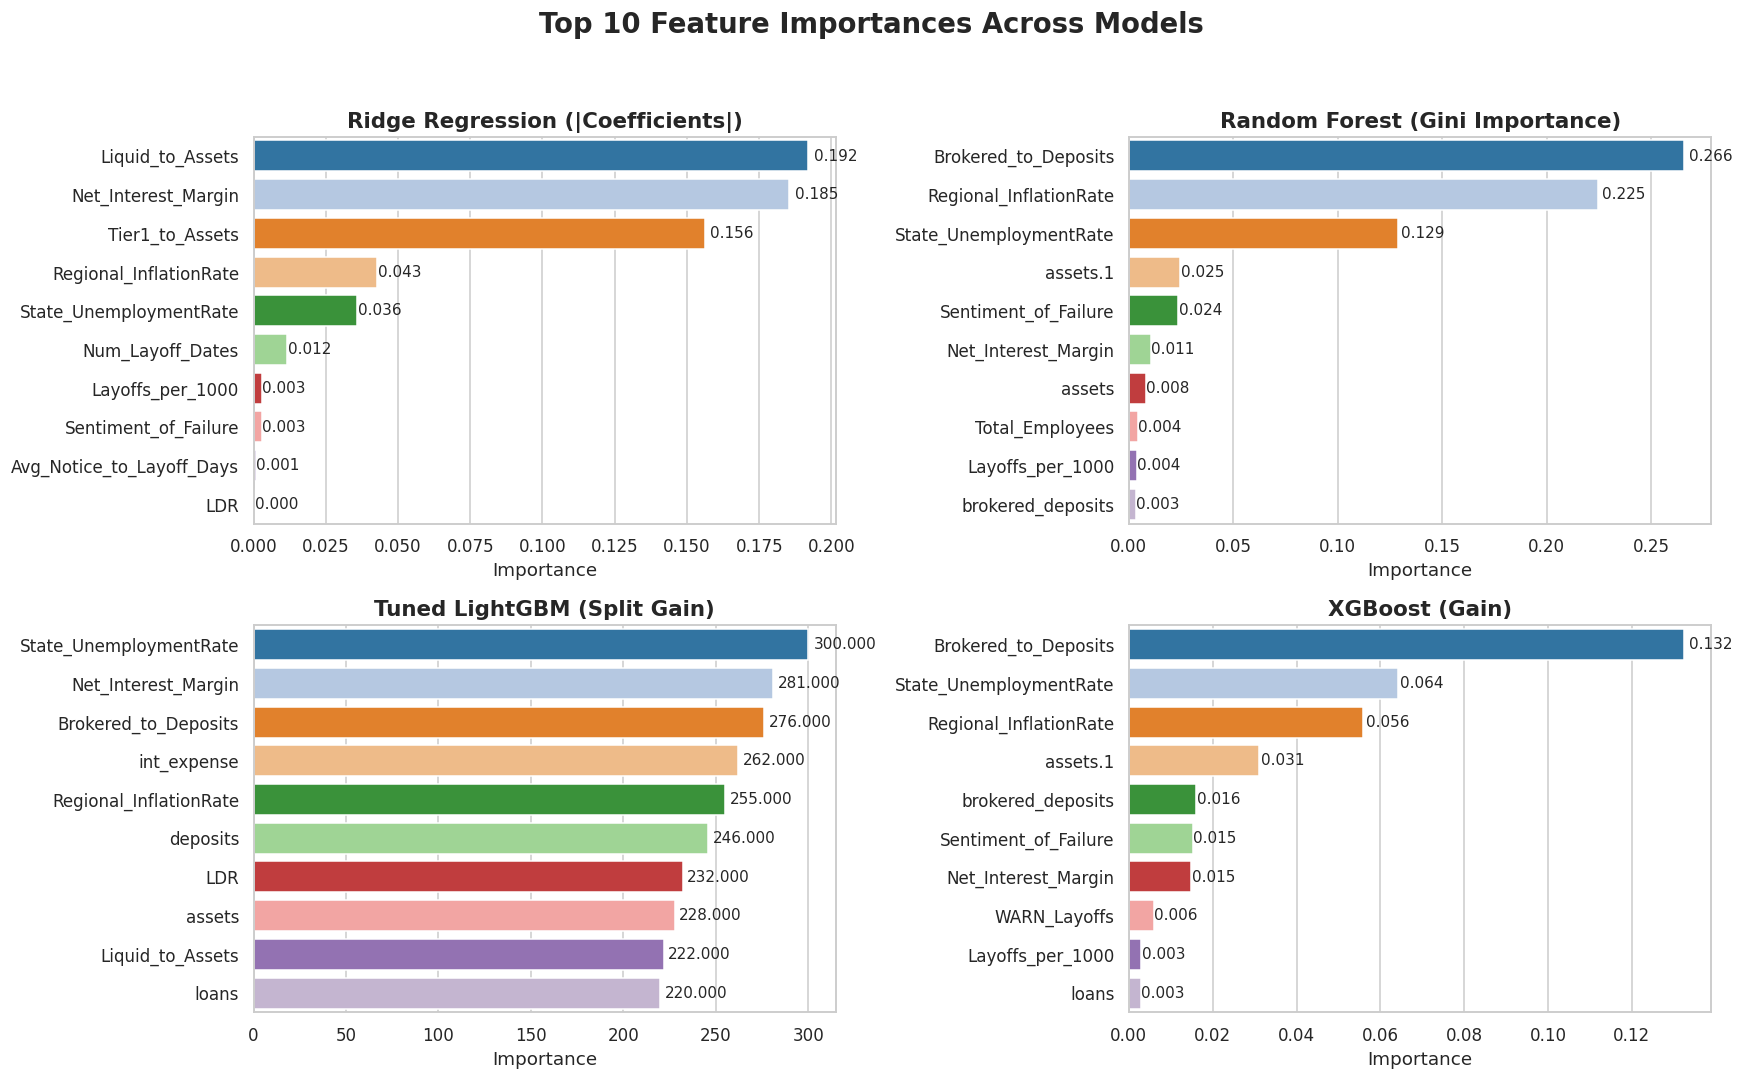

In [ ]:
# Fit untuned baseline models
rf_model = RandomForestRegressor(random_state=42)
ridge_model = Ridge()
xgb_model = XGBRegressor(random_state=42)

rf_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Exclude Quarter Feature
exclude_features = ["Quarter"]

# Extract top N features
def get_top_features(importances, feature_names, top_n=10):
    df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    df = df[~df['Feature'].isin(exclude_features)]
    df = df.sort_values(by='Importance', ascending=False).head(top_n)
    return df

# Ridge Regression
ridge_importances = np.abs(ridge_model.coef_)
ridge_df = get_top_features(ridge_importances, X_train.columns)

# Random Forest
rf_df = get_top_features(rf_model.feature_importances_, X_train.columns)

# Tuned LightGBM
lgb_df = get_top_features(tuned_lgb.feature_importances_, tuned_lgb.feature_name_)

# XGBoost
xgb_df = get_top_features(xgb_model.feature_importances_, xgb_model.feature_names_in_)

# Plot Setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=110)
fig.suptitle("Top 10 Feature Importances Across Models", fontsize=18, fontweight='bold')

color_palette = sns.color_palette("tab20", n_colors=10)

# Plotting Function
def plot_importance_bar(ax, df, title):
    sns.barplot(
        ax=ax,
        x="Importance",
        y="Feature",
        data=df,
        palette=color_palette
    )
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Importance", fontsize=12)
    ax.set_ylabel("")
    ax.tick_params(labelsize=11)

    for i, (val, _) in enumerate(zip(df["Importance"], df["Feature"])):
        ax.text(val * 1.01, i, f"{val:.3f}", va='center', fontsize=10)

# Create Each Plot
plot_importance_bar(axes[0, 0], ridge_df, "Ridge Regression (|Coefficients|)")
plot_importance_bar(axes[0, 1], rf_df, "Random Forest (Gini Importance)")
plot_importance_bar(axes[1, 0], lgb_df, "Tuned LightGBM (Split Gain)")
plot_importance_bar(axes[1, 1], xgb_df, "XGBoost (Gain)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.85054e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


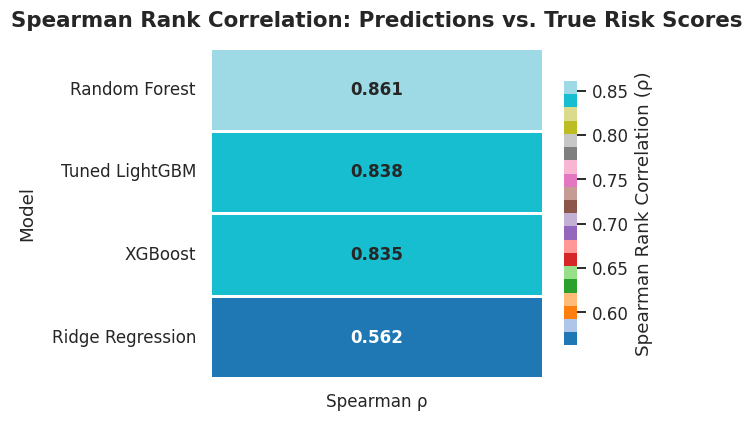

In [ ]:
# Spearman Rank Correlation Coefficient Bar Chart
# Refit Untuned Models
rf_model = RandomForestRegressor(random_state=42)
ridge_model = Ridge()
xgb_model = XGBRegressor(random_state=42)

rf_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Predictions from all models
predictions = {
    "Tuned LightGBM": tuned_lgb.predict(X_test),
    "XGBoost": xgb_model.predict(X_test),
    "Random Forest": rf_model.predict(X_test),
    "Ridge Regression": ridge_model.predict(X_test)
}

# Compute Spearman ρ
spearman_scores = {
    model: spearmanr(pred, y_test).correlation
    for model, pred in predictions.items()
}

# Format as DataFrame
spearman_df = pd.DataFrame.from_dict(spearman_scores, orient='index', columns=["Spearman ρ"])
spearman_df = spearman_df.sort_values(by="Spearman ρ", ascending=False)

# Define custom colormap
pastel_colors = sns.color_palette("BuGn", 20)
pastel_cmap = ListedColormap(pastel_colors)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4), dpi=110)

ax = sns.heatmap(
    spearman_df,
    annot=True,
    cmap=tab20_cmap,
    fmt=".3f",
    linewidths=0.7,
    cbar_kws={
        'label': 'Spearman Rank Correlation (ρ)',
        'shrink': 0.8,
        'orientation': 'vertical'
    },
    annot_kws={"size": 11, "weight": "bold"}
)

# Title and axes
ax.set_ylabel("Model", fontsize=12, labelpad=10)
plt.title("Spearman Rank Correlation: Predictions vs. True Risk Scores", fontsize=14, fontweight='bold', pad=14)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(rotation=0, fontsize=11)
ax.figure.axes[-1].yaxis.label.set_size(12)

plt.tight_layout()
plt.show()

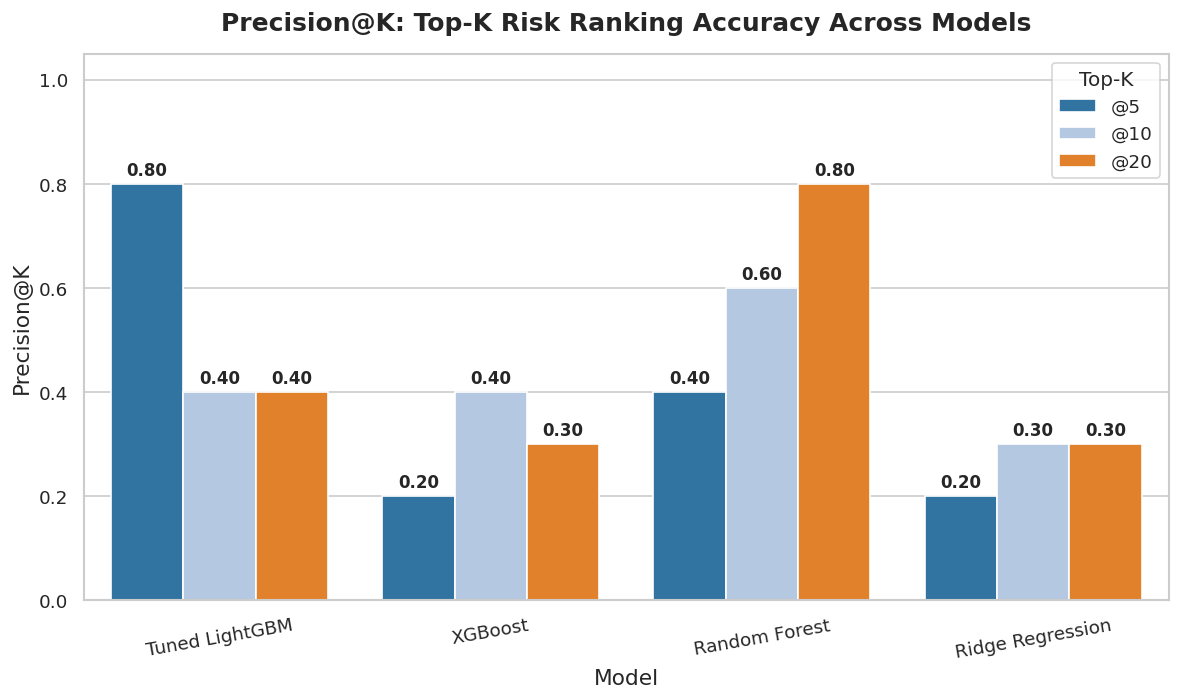

In [ ]:
# Precision@K function
def precision_at_k(y_true, y_pred, k):
    pred_top_k = np.argsort(y_pred)[-k:][::-1]
    true_top_k = np.argsort(y_true)[-k:][::-1]
    return len(set(pred_top_k) & set(true_top_k)) / k

# Define K values
k_values = [5, 10, 20]

# Collect predictions
predictions = {
    "Tuned LightGBM": tuned_lgb.predict(X_test),
    "XGBoost": xgb_model.predict(X_test),
    "Random Forest": rf_model.predict(X_test),
    "Ridge Regression": ridge_model.predict(X_test)
}

# Compute Precision@K
precision_records = []
for k in k_values:
    for model_name, preds in predictions.items():
        score = precision_at_k(y_test.values, preds, k)
        precision_records.append({
            "Model": model_name,
            "K": f"@{k}",
            "Precision@K": score
        })

precision_df = pd.DataFrame(precision_records)

# Plotting
sns.set(style="whitegrid")
tab20_colors = sns.color_palette("tab20", len(predictions))

plt.figure(figsize=(10, 6), dpi=120)
ax = sns.barplot(
    data=precision_df,
    x="Model",
    y="Precision@K",
    hue="K",
    palette=tab20_colors[:len(k_values)]
)

# Label bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10, weight='bold')

# Formatting
plt.title("Precision@K: Top-K Risk Ranking Accuracy Across Models", fontsize=15, fontweight='bold', pad=14)
plt.xlabel("Model", fontsize=13)
plt.ylabel("Precision@K", fontsize=13)
plt.ylim(0, 1.05)
plt.xticks(rotation=10, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title="Top-K", title_fontsize=12, fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()